# Practice 3
# 1. Simulation of the Eigenstructure of a Finite Potential Well (as a Heterostructure)

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

### Constants & Parameters

In [2]:
# CONSTANTS SI---------------------------
hbar_SI = 1.054571817e-34 # J.s
m_e_SI = 9.1093837015e-31 # kg
e_SI = 1.602176634e-19 # C
a_B_SI = 5.291772109e-11 # m
E_H_SI = hbar_SI**2/(m_e_SI*a_B_SI**2) # J # will use eV instead of Hartrees
c = 299792458 # m/s

evToJ = e_SI

# ATOMIC UNITS------------------------------
hbar=1
e=1 # Fundamtl charge
m_e=1 # Electron mass
a_B=1 # Bohr radious

# X NODES-----------------------------------
N = 3000 # Number of Nodes in the (spatial) Grid
x_min_SI = -30e-9 # m
x_max_SI = 30e-9 # m

x_min = x_min_SI/a_B_SI
x_max = x_max_SI/a_B_SI

dx = (x_max-x_min)/(N-1)
x_nodes = x_min+np.arange(N)*dx

# MASSES------------------------------------
m_ef_e = 0.06*m_e 
m_ef_h = 0.4*m_e
num_eig = 4 # Number of Eigenvectors and Eigenstates to Output

# SCENARIO----------------------------------
L_SI = 7e-9 # m
Egap_well_SI = 1.8*evToJ # J
Egap_barrier_SI = 2.3*evToJ # J
valence_prop = 0.4
conduction_prop = 1-valence_prop


L = L_SI/a_B_SI
Egap_well = Egap_well_SI/E_H_SI
Egap_barrier=Egap_barrier_SI/E_H_SI

E_barrier_e = (Egap_barrier-Egap_well)*conduction_prop
E_well_e = Egap_well/2

E_barrier_h = (Egap_barrier-Egap_well)*valence_prop
E_well_h = Egap_well/2

### Define Routines

In [3]:
def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)


def E_band(x_nodes, L, E_well, E_barrier): # symmetric barrier around x=0
    E_b = np.ones(len(x_nodes))*E_well
    E_b[ x_nodes<=-L/2 ]+=E_barrier
    E_b[ x_nodes>=L/2 ]+=E_barrier
    return E_b


def V_ext(x_nodes):
    return np.zeros(len(x_nodes))


def initialize_Discretized_Hamiltonian_and_Band(m, E_band, V_ext, N, x_nodes, L, E_well, E_barrier):
    E_b = E_band(x_nodes, L, E_well, E_barrier)
    sub_diagonals=-hbar**2/(2*m*dx**2)*np.ones(N-1)
    main_diagonal=hbar**2/(m*dx**2)*np.ones(N)+E_b+V_ext(x_nodes)
    
    H=tridiag(sub_diagonals, main_diagonal, sub_diagonals)
    # Implicitly using infinite barrier BC outside the simulation domain F[-1]=0=F[N]
    return H, E_b


def obtain_Eigenstates_and_Eigenergies(H, num_eig):
    return linalg.eigh(H, subset_by_index=[0,num_eig-1], eigvals_only=False) #[num_eig], [N, num_eig]

def to_eV_and_nm(x_nodes, Es_e, Es_h, E_band_e, E_band_h):
    return x_nodes*a_B_SI*10**9, Es_e*E_H_SI/evToJ, Es_h*E_H_SI/evToJ, E_band_e*E_H_SI/evToJ, E_band_h*E_H_SI/evToJ

def plot_Eigenstates_and_Eigenergies_pdf(x_nodes, Es_e, phis_e, Es_h, phis_h, E_band_e, E_band_h, max_phi=0.07):
    x_nodes, Es_e, Es_h, E_band_e, E_band_h = to_eV_and_nm(
                x_nodes, Es_e, Es_h, E_band_e, E_band_h)
    
    fig, axs = plt.subplots(3, 1, figsize=(10,18))
    ax2 = axs[0].twinx()
    ax2.set_ylabel("|psi|^2")
    ax2.set_ylim((0,max_phi))
    axs[0].plot(x_nodes, E_band_e, label="E_conduction_band", color='k')
    intv_phi = (0, max_phi)
    ax2.set_ylim(intv_phi[0]-0.05*(intv_phi[1]-intv_phi[0]), intv_phi[1]+0.05*(intv_phi[1]-intv_phi[0]))
    intv_E = (0.9,1.25)
    axs[0].set_ylim(intv_E[0]-0.05*(intv_E[1]-intv_E[0]), intv_E[1]+0.05*(intv_E[1]-intv_E[0]))
    for k, (E, phi) in enumerate(zip(Es_e, phis_e.T)):
        ax2.plot(x_nodes, np.abs(phi)**2+(E-intv_E[0])/(intv_E[1]-intv_E[0])*(intv_phi[1]-intv_phi[0]),
                 label=f"|psi_e|^2 n={k} E={E:.4}eV")
    ax2.legend(bbox_to_anchor=(1.5, 0.5))
    ax2.set_ymargin(0.5)
    axs[0].set_xlabel("x (nm)")
    axs[0].set_ylabel("E (eV)")
    axs[0].set_title("Envelope of Bounded Conduction Band Carriers (electrons)")
    
    ax2 = axs[1].twinx()
    ax2.set_ylabel("|psi|^2")
    ax2.set_ylim((0,max_phi))
    axs[1].plot(x_nodes, E_band_h, label="E_valence_band", color='k')
    intv_phi = (0, max_phi)
    ax2.set_ylim(intv_phi[0]-0.05*(intv_phi[1]-intv_phi[0]), intv_phi[1]+0.05*(intv_phi[1]-intv_phi[0]))
    intv_E = (0.9,1.125)
    axs[1].set_ylim(intv_E[0]-0.05*(intv_E[1]-intv_E[0]), intv_E[1]+0.05*(intv_E[1]-intv_E[0]))
    for k, (E, phi) in enumerate(zip(Es_h, phis_h.T)):
        ax2.plot(x_nodes, np.abs(phi)**2+(E-intv_E[0])/(intv_E[1]-intv_E[0])*(intv_phi[1]-intv_phi[0]),
                 label=f"|psi_h|^2 n={k} E={-E:.4}eV")
    ax2.legend(bbox_to_anchor=(1.5, 0.5))
    axs[1].set_xlabel("x (nm)")
    axs[1].set_ylabel("-E (eV)")
    axs[1].set_title("Envelope of Bounded Valence Band Carriers (holes)")
    max_phi=0.1
    axs[2].plot(x_nodes, -E_band_h, '-', label="E_valence_band", color='b')
    axs[2].plot(x_nodes, E_band_e, label="E_conduction_band", color='k')
    axs[2].set_title("Envelope of Bounded States - Band Structure")
    ax2 = axs[2].twinx()
    intv_phi = (-max_phi-0.05*max_phi*2, max_phi+0.05*max_phi*2)
    ax2.set_ylim(intv_phi)
    intv_E = (-1.2,1.2)
    axs[2].set_ylim(intv_E[0]-0.05*2.4, intv_E[1]+0.05*2.4)
    #intv_E = intv_E+np.array((-1,1))*axs[2].margins()*(intv_E[1]-intv_E[0])
    for k, (E, phi) in enumerate(zip(Es_h, phis_h.T)):
        ax2.plot(x_nodes, -np.abs(phi)**2-E/(intv_E[1]-intv_E[0])*(2*max_phi),
                 label=f"|psi_h|^2 n={k} E={-E:.4}eV")
    for k, (E, phi) in enumerate(zip(Es_e, phis_e.T)):
        ax2.plot(x_nodes, np.abs(phi)**2+(E)/(intv_E[1]-intv_E[0])*(2*max_phi),
                 label=f"|psi_e|^2 n={k} E={E:.4}eV")
    ax2.legend(bbox_to_anchor=(1.5, 0.5))
    ax2.set_ylabel("|psi|^2")
    axs[2].set_xlabel("x (nm)")
    axs[2].set_ylabel("E (eV)")
    axs[0].legend(bbox_to_anchor=(1.4, 0.85))
    axs[1].legend(bbox_to_anchor=(1.4, 0.85))
    axs[2].legend(bbox_to_anchor=(1.4, 0.85))

    
    plt.savefig("Eigen_pdf.png", dpi=100, bbox_inches='tight')
    plt.show()    

In [4]:
def plot_Eigenstates_and_Eigenergies_Real(x_nodes, Es_e, phis_e, Es_h, phis_h, E_band_e, E_band_h, max_phi=0.63):
    x_nodes, Es_e, Es_h, E_band_e, E_band_h = to_eV_and_nm(
                x_nodes, Es_e, Es_h, E_band_e, E_band_h)
    
    fig, axs = plt.subplots(3, 1, figsize=(10,18))
    ax2 = axs[0].twinx()
    ax2.set_ylabel("Re{psi}")
    ax2.set_ylim((0,max_phi))
    axs[0].plot(x_nodes, E_band_e, label="E_conduction_band", color='k')
    intv_phi = (0, max_phi)
    ax2.set_ylim(intv_phi[0]-0.05*(intv_phi[1]-intv_phi[0]), intv_phi[1]+0.05*(intv_phi[1]-intv_phi[0]))
    intv_E = (0.9,1.25)
    axs[0].set_ylim(intv_E[0]-0.05*(intv_E[1]-intv_E[0]), intv_E[1]+0.05*(intv_E[1]-intv_E[0]))
    for k, (E, phi) in enumerate(zip(Es_e, phis_e.T)):
        ax2.plot(x_nodes, phi+(E-intv_E[0])/(intv_E[1]-intv_E[0])*(intv_phi[1]-intv_phi[0]),
                 label=f"Re[psi_e] n={k} E={E:.4}eV")
    ax2.legend(bbox_to_anchor=(1.5, 0.5))
    ax2.set_ymargin(0.5)
    axs[0].set_xlabel("x (nm)")
    axs[0].set_ylabel("E (eV)")
    axs[0].set_title("Envelope of Bounded Conduction Band Carriers (electrons)")
    
    ax2 = axs[1].twinx()
    ax2.set_ylabel("Re{psi}")
    ax2.set_ylim((0,max_phi))
    axs[1].plot(x_nodes, E_band_h, label="E_valence_band", color='k')
    intv_phi = (0, max_phi)
    ax2.set_ylim(intv_phi[0]-0.05*(intv_phi[1]-intv_phi[0]), intv_phi[1]+0.05*(intv_phi[1]-intv_phi[0]))
    intv_E = (0.9,1.125)
    axs[1].set_ylim(intv_E[0]-0.05*(intv_E[1]-intv_E[0]), intv_E[1]+0.05*(intv_E[1]-intv_E[0]))
    for k, (E, phi) in enumerate(zip(Es_h, phis_h.T)):
        ax2.plot(x_nodes, phi+(E-intv_E[0])/(intv_E[1]-intv_E[0])*(intv_phi[1]-intv_phi[0]),
                 label=f"Re[psi_h] n={k} E={-E:.4}eV")
    ax2.legend(bbox_to_anchor=(1.5, 0.5))
    axs[1].set_xlabel("x (nm)")
    axs[1].set_ylabel("-E (eV)")
    axs[1].set_title("Envelope of Bounded Valence Band Carriers (holes)")
    max_phi=0.85
    axs[2].plot(x_nodes, -E_band_h, '-', label="E_valence_band", color='b')
    axs[2].plot(x_nodes, E_band_e, label="E_conduction_band", color='k')
    axs[2].set_title("Envelope of Bounded States - Band Structure")
    ax2 = axs[2].twinx()
    intv_phi = (-max_phi-0.05*max_phi*2, max_phi+0.05*max_phi*2)
    ax2.set_ylim(intv_phi)
    intv_E = (-1.2,1.2)
    axs[2].set_ylim(intv_E[0]-0.05*2.4, intv_E[1]+0.05*2.4)
    #intv_E = intv_E+np.array((-1,1))*axs[2].margins()*(intv_E[1]-intv_E[0])
    for k, (E, phi) in enumerate(zip(Es_h, phis_h.T)):
        ax2.plot(x_nodes, -phi-E/(intv_E[1]-intv_E[0])*(2*max_phi),
                 label=f"Re[psi_h] n={k} E={-E:.4}eV")
    for k, (E, phi) in enumerate(zip(Es_e, phis_e.T)):
        ax2.plot(x_nodes, phi+(E)/(intv_E[1]-intv_E[0])*(2*max_phi),
                 label=f"Re[psi_e] n={k} E={E:.4}eV")
    ax2.legend(bbox_to_anchor=(1.5, 0.5))
    ax2.set_ylabel("Re{psi}")
    axs[2].set_xlabel("x (nm)")
    axs[2].set_ylabel("E (eV)")
    axs[0].legend(bbox_to_anchor=(1.4, 0.85))
    axs[1].legend(bbox_to_anchor=(1.4, 0.85))
    axs[2].legend(bbox_to_anchor=(1.4, 0.85))

    
    plt.savefig("Eigen_Re.png", dpi=100, bbox_inches='tight')
    plt.show()    

### Compute Eigenstates and Eigenvalues and Plot

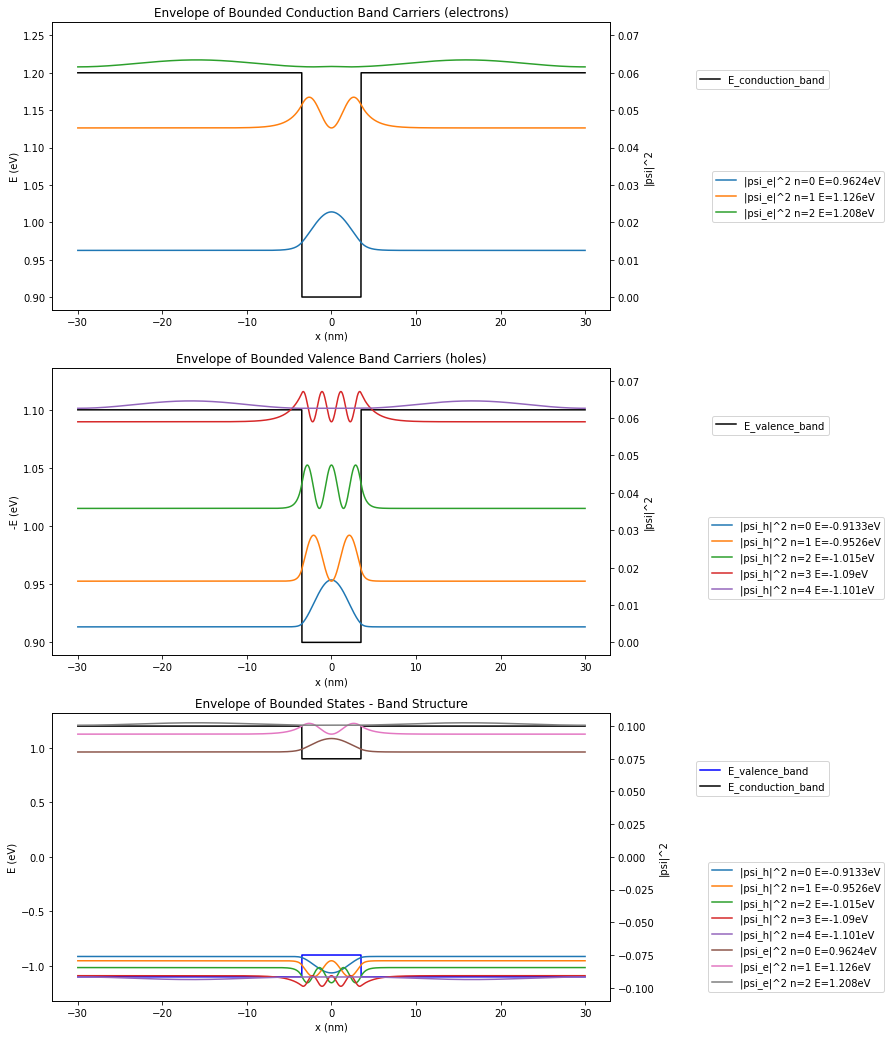

In [10]:
H_e, E_band_e = initialize_Discretized_Hamiltonian_and_Band(m_ef_e, E_band, V_ext, N, x_nodes, L, E_well_e, E_barrier_e)
Es_e, phis_e = obtain_Eigenstates_and_Eigenergies(H_e, 3)

H_h, E_band_h = initialize_Discretized_Hamiltonian_and_Band(m_ef_h, E_band, V_ext, N, x_nodes, L, E_well_h, E_barrier_h)
Es_h, phis_h = obtain_Eigenstates_and_Eigenergies(H_h, 5)

phis_e = phis_e/np.sqrt(dx) # We normalize the eigenstates to the integral of the squared (phis_e already unit vectors if squared for RN norm)
phis_h = phis_h/np.sqrt(dx)

plot_Eigenstates_and_Eigenergies_pdf(x_nodes, Es_e, phis_e, Es_h, phis_h, E_band_e, E_band_h) 

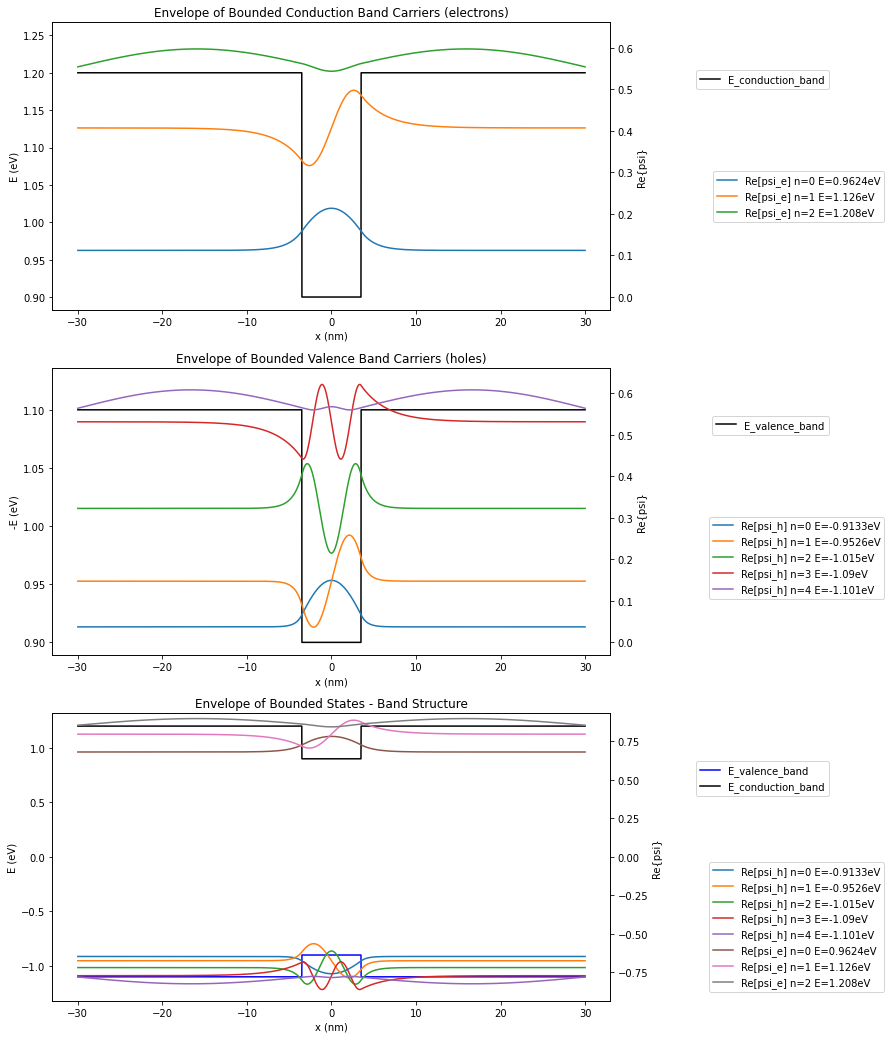

In [11]:
plot_Eigenstates_and_Eigenergies_Real(x_nodes, Es_e, phis_e, Es_h, phis_h, E_band_e, E_band_h) 

### Energy of Transition

In [7]:
Es_e_=Es_e*E_H_SI/evToJ
Es_h_=Es_h*E_H_SI/evToJ

GS_GS = Es_e_[0]+Es_h_[0]
lambda_GS_GS = hbar_SI*c*2*np.pi/((Es_e_[0]+Es_h_[0])*e_SI)*10**9

ES1_ES1 = Es_e_[1]+Es_h_[1]
lambda_ES1_ES1 = hbar_SI*c*2*np.pi/((Es_e_[1]+Es_h_[1])*e_SI)*10**9

print(f"GS e to GS h -> {GS_GS} eV -> {lambda_GS_GS} nm")
print(f"1ES e to 1ES h -> {ES1_ES1} eV -> {lambda_ES1_ES1} nm")
print(f"Avg -> {0.5*(GS_GS+ES1_ES1)} eV -> {0.5*(lambda_ES1_ES1+lambda_GS_GS)} nm")

GS e to GS h -> 1.875702460257682 eV -> 661.0014167182995 nm
1ES e to 1ES h -> 2.0788515602618443 eV -> 596.4071736878423 nm
Avg -> 1.9772770102597632 eV -> 628.7042952030708 nm


### Infinite Potential Energy Well Model Prediction

In [8]:
def E_infinite(n, m, L, E_well, hbar=hbar):
    return E_well+n**2*np.pi**2*hbar**2/(2*m*L**2)

Es_e_inf = np.array([E_infinite(n, m_ef_e, L, E_well_e, hbar) for n in range(1,6)])*E_H_SI/evToJ
Es_h_inf = np.array([E_infinite(n, m_ef_h, L, E_well_h, hbar) for n in range(1,6)])*E_H_SI/evToJ

GS_GS_inf = Es_e_inf[0]+Es_h_inf[0]
lambda_GS_GS_inf = hbar_SI*c*2*np.pi/((Es_e_inf[0]+Es_h_inf[0])*e_SI)*10**9

ES1_ES1_inf = Es_e_inf[1]+Es_h_inf[1]
lambda_ES1_ES1_inf = hbar_SI*c*2*np.pi/((Es_e_inf[1]+Es_h_inf[1])*e_SI)*10**9

print(f"GS e to GS h -> {GS_GS_inf} eV -> {lambda_GS_GS_inf} nm")
print(f"1ES e to 1ES h -> {ES1_ES1_inf} eV -> {lambda_ES1_ES1_inf} nm")
print(f"Avg -> {0.5*(GS_GS_inf+ES1_ES1_inf)} eV -> {0.5*(lambda_ES1_ES1_inf+lambda_GS_GS_inf)} nm")

GS e to GS h -> 1.9470866280541925 eV -> 636.7677563536837 nm
1ES e to 1ES h -> 2.38834651221677 eV -> 519.1214830973395 nm
Avg -> 2.1677165701354815 eV -> 577.9446197255115 nm


In [9]:
print(f"GS e to GS h , inifnite-finite difference {GS_GS_inf-GS_GS} eV")
print(f"1ES e to 1ES h , inifnite-finite difference {ES1_ES1_inf-ES1_ES1} eV")
print(f"Smallest Transition energy infinite-finite difference {lambda_GS_GS_inf-lambda_GS_GS} nm")

GS e to GS h , inifnite-finite difference 0.07138416779651058 eV
1ES e to 1ES h , inifnite-finite difference 0.30949495195492593 eV
Smallest Transition energy infinite-finite difference -24.233660364615844 nm


In [12]:
np.log(1.78)

0.5766133643039938

## Results to Table

In [28]:
import pandas as pd
data1 = pd.DataFrame(data={'n': np.arange(5)+1,'CB Bounded States (eV)':Es_e_, 'Inf. Wall Apprx CB (eV)':Es_e_inf, 
                   'Abs. Error':Es_e_inf-Es_e_})
data2 = pd.DataFrame(data={'n':np.arange(5)+1, 'VB Bounded States (eV)':-Es_h_, 'Inf. Wall Apprx VB (eV)':-Es_h_inf, 
                   'Abs. Error':-Es_h_inf+Es_h_})
print(data1.to_latex(float_format="%.3f", index=False))
print(data2.to_latex(float_format="%.3f", index=False))

\begin{tabular}{rrrr}
\toprule
 n &  CB Bounded States (eV) &  Inf. Wall Apprx CB (eV) &  Abs. Error \\
\midrule
 1 &                   0.962 &                    1.028 &       0.066 \\
 2 &                   1.126 &                    1.412 &       0.285 \\
 3 &                   1.208 &                    2.051 &       0.843 \\
 4 &                   1.210 &                    2.946 &       1.737 \\
 5 &                   1.231 &                    4.098 &       2.866 \\
\bottomrule
\end{tabular}

\begin{tabular}{rrrr}
\toprule
 n &  VB Bounded States (eV) &  Inf. Wall Apprx VB (eV) &  Abs. Error \\
\midrule
 1 &                  -0.913 &                   -0.919 &      -0.006 \\
 2 &                  -0.953 &                   -0.977 &      -0.024 \\
 3 &                  -1.015 &                   -1.073 &      -0.057 \\
 4 &                  -1.090 &                   -1.207 &      -0.117 \\
 5 &                  -1.101 &                   -1.380 &      -0.278 \\
\bottomrule
\end{

In [38]:
np.sqrt((np.pi**2*hbar_SI**2*0.5*(1/m_ef_e+1/m_ef_h)/m_e_SI)/(hbar_SI*c*2*np.pi/(650e-9)-1.8*evToJ))

8.189983592135712e-09

## Given Observed $\lambda$, look for Optimal Well width

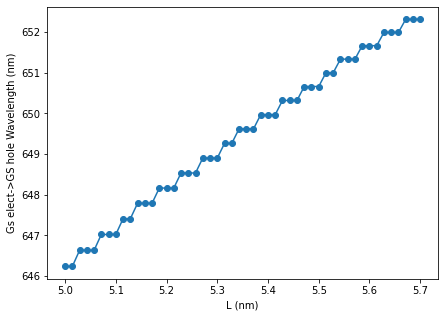

The closest found configuration is L=5.385714285714286nm with a e GS->h GS transition of lambda=649.9679069262786nm


In [29]:
objective_lambda = 650 # nm -> Will need to be smaller than 7 nm
# We will perform a Brute Force Search in a Grid
num_Ls=50
L0=5
Lf=5.7
Ls_SI = (L0+(Lf-L0)*np.arange(num_Ls)/(num_Ls-1))*10**-9
Ls=Ls_SI/a_B_SI

lambdas =[]

for L in Ls:
    H_e, E_band_e = initialize_Discretized_Hamiltonian_and_Band(m_ef_e, E_band, V_ext, N, x_nodes, L, E_well_e, E_barrier_e)
    Es_e, phis_e = obtain_Eigenstates_and_Eigenergies(H_e, 1)

    H_h, E_band_h = initialize_Discretized_Hamiltonian_and_Band(m_ef_h, E_band, V_ext, N, x_nodes, L, E_well_h, E_barrier_h)
    Es_h, phis_h = obtain_Eigenstates_and_Eigenergies(H_h, 1)
    
    Es_e_=Es_e*E_H_SI/evToJ
    Es_h_=Es_h*E_H_SI/evToJ
    
    lambdas.append(hbar_SI*c*2*np.pi/((Es_e_[0]+Es_h_[0])*e_SI)*10**9)

fig,ax=plt.subplots(1,1,figsize=(7,5))
ax.plot(Ls_SI*10**9, lambdas, 'o-')
ax.set_xlabel("L (nm)")
ax.set_ylabel("Gs elect->GS hole Wavelength (nm)")
plt.show()

closest_idx = np.argmin(np.abs(np.array(lambdas)-objective_lambda))
print(f"The closest found configuration is L={Ls_SI[closest_idx]*10**9}nm with a e GS->h GS transition of lambda={lambdas[closest_idx]}nm")

## 2. Laser Diode Characterization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

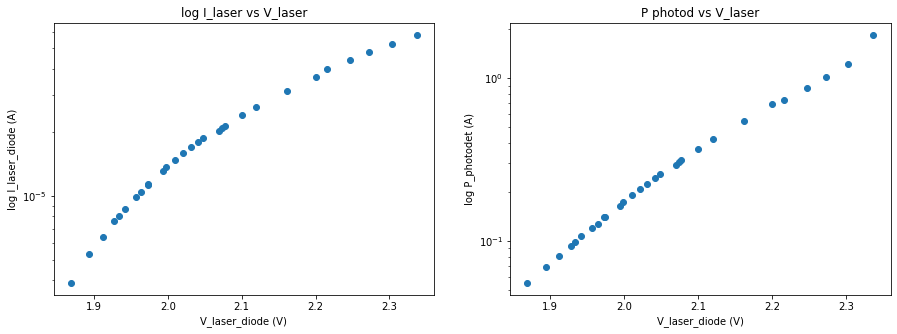

In [2]:
R_opamp=100
R_diodo=100e3
V_photo=15

data=pd.read_excel("Practice3_NIC.xlsx", header=None)

V_laser=np.asarray(data[0][1:])
V_R_post_laser=np.asarray(data[1][1:])
V_post_opamp=np.asarray(data[2][1:])

I_photodet = V_post_opamp/R_opamp
I_laser = V_R_post_laser/R_diodo
P_photodet = V_photo*I_photodet
V_laser=V_laser.astype(np.float64)
I_laser=I_laser.astype(np.float64)
P_photodet=P_photodet.astype(np.float64)

fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(V_laser, I_laser, 'o')

ax[0].set_ylabel("log I_laser_diode (A)")
ax[0].set_xlabel("V_laser_diode (V)")
ax[0].set_title("log I_laser vs V_laser")
ax[0].set_yscale('log')

ax[1].plot(V_laser, P_photodet, 'o')

ax[1].set_ylabel("log P_photodet (A)")
ax[1].set_xlabel("V_laser_diode (V)")
ax[1].set_title("P photod vs V_laser")
ax[1].set_yscale('log')
plt.show()

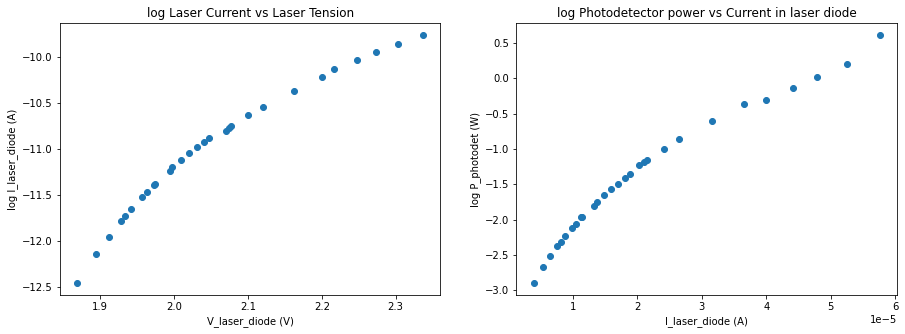

In [5]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(V_laser, np.log(I_laser), 'o')

ax[0].set_ylabel("log I_laser_diode (A)")
ax[0].set_xlabel("V_laser_diode (V)")
ax[0].set_title("log Laser Current vs Laser Tension")
#ax[0].set_yscale('log')

ax[1].plot(I_laser, np.log(P_photodet), 'o')

ax[1].set_ylabel("log P_photodet (W)")
ax[1].set_xlabel("I_laser_diode (A)")
ax[1].set_title("log Photodetector power vs Current in laser diode")
#ax[1].set_yscale('log')
plt.savefig("No_Fit.png", dpi=300)

plt.show()

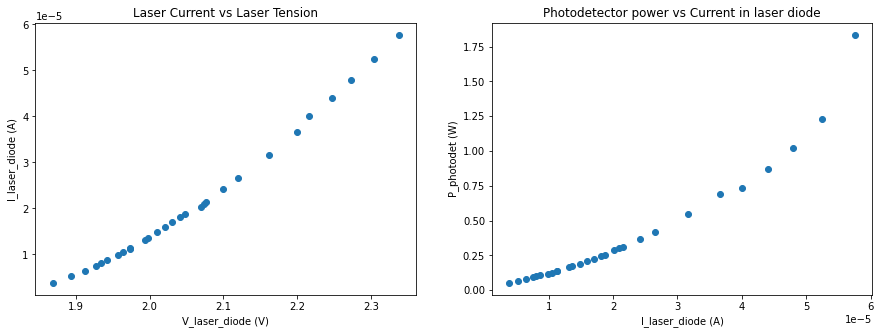

In [3]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(V_laser, I_laser, 'o')

ax[0].set_ylabel("I_laser_diode (A)")
ax[0].set_xlabel("V_laser_diode (V)")
ax[0].set_title("Laser Current vs Laser Tension")
#ax[0].set_yscale('log')

ax[1].plot(I_laser, P_photodet, 'o')

ax[1].set_ylabel("P_photodet (W)")
ax[1].set_xlabel("I_laser_diode (A)")
ax[1].set_title("Photodetector power vs Current in laser diode")
#ax[1].set_yscale('log')
plt.savefig("No_Fit_No_log.png", dpi=300)

plt.show()

12 float64 float64


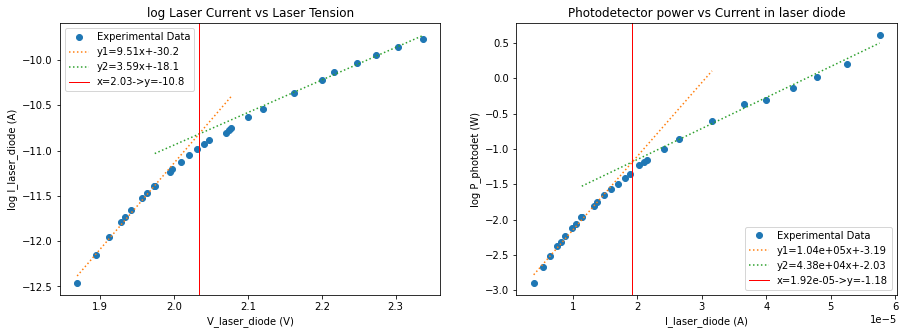

In [8]:
th11=2.0
th12=2.1
th21=1.8e-5
th22=2.5e-5


print(np.where(V_laser>th11)[0][0],  V_laser[:np.where(V_laser>th11)[0][0]].dtype, I_laser[:np.where(V_laser>th11)[0][0]].dtype)

fig, ax = plt.subplots(1,2,figsize=(15,5))

a11,b11=np.polyfit( V_laser[np.where(V_laser<th11)], np.log(I_laser[np.where(V_laser<th11)]), 1)
a12,b12=np.polyfit( V_laser[np.where(V_laser>th12)], np.log(I_laser[np.where(V_laser>th12)]), 1)
a21,b21=np.polyfit( I_laser[np.where(I_laser<th21)], np.log(P_photodet[np.where(I_laser<th21)]), 1)
a22,b22=np.polyfit( I_laser[np.where(I_laser>th22)], np.log(P_photodet[np.where(I_laser>th22)]), 1)
int1=(b11-b12)/(a12-a11)
int2=(b22-b21)/(a21-a22)

ax[0].plot(V_laser, np.log(I_laser), 'o', label=f"Experimental Data")
ax[0].plot(V_laser[:(np.argwhere(V_laser>th11)[0,0]+8)], b11+a11*V_laser[:(np.argwhere(V_laser>th11)[0,0]+8)],  ':', label=f"y1={a11:.3}x+{b11:.3}")
ax[0].plot(V_laser[np.argwhere(V_laser>th12)[0,0]-12:], b12+a12*V_laser[np.argwhere(V_laser>th12)[0,0]-12:],  ':', label=f"y2={a12:.3}x+{b12:.3}" )
ax[0].axvline(int1, color='red', linewidth=1, label=f"x={int1:.3}->y={b11+a11*int1:.3}")
ax[0].set_ylabel("log I_laser_diode (A)")
ax[0].set_xlabel("V_laser_diode (V)")
ax[0].set_title("log Laser Current vs Laser Tension")
#ax[0].set_yscale('log')

ax[1].plot(I_laser, np.log(P_photodet), 'o', label=f"Experimental Data")
ax[1].plot(I_laser[:(np.argwhere(I_laser>th21)[0,0]+8)], b21+a21*I_laser[:(np.argwhere(I_laser>th21)[0,0]+8)],  ':', label=f"y1={a21:.3}x+{b21:.3}")
ax[1].plot(I_laser[np.argwhere(I_laser>th22)[0,0]-12:], b22+a22*I_laser[np.argwhere(I_laser>th22)[0,0]-12:],  ':', label=f"y2={a22:.3}x+{b22:.3}")

ax[1].set_ylabel("log P_photodet (W)")
ax[1].set_xlabel("I_laser_diode (A)")
ax[1].set_title("Photodetector power vs Current in laser diode")
ax[1].axvline(int2, color='red', linewidth=1, label=f"x={int2:.3}->y={b21+a21*int2:.3}")

ax[1].legend()
ax[0].legend()
#ax[1].set_yscale('log')
plt.savefig("Fitted.png", dpi=300)
plt.show()